In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

: 

In [2]:
filename = '/global/cfs/cdirs/m4287/cosmology/dessn/autoscan_features.3.csv'

df = pd.read_csv(filename, skiprows=7, usecols=[0, 1], header=None, names=['ID', 'OBJECT_TYPE'])
labels_dict = dict(zip(df['ID'], df['OBJECT_TYPE']))

In [3]:
file_dict = {'srch': {}, 'diff': {}, 'temp': {}}
root_dir = "/pscratch/sd/b/bthorne/fairuniverse/portal.nersc.gov/project/dessn/autoscan/stamps"
#traverse_directory(root_dir, file_dict)

In [72]:
dataset = DESFitsDataset(root_dir, labels_dict)
#data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [73]:
data_loader = DataLoader(dataset, batch_size=10)

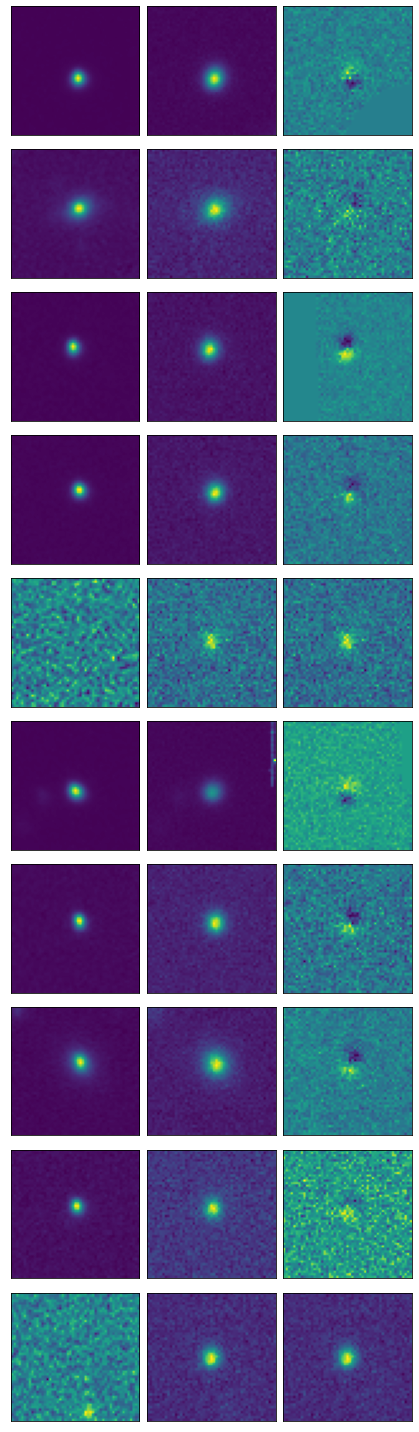

In [74]:
def plot_batch(batch):
    nbatch = batch.shape[0]
    ncols = 3
    figsize = (3 * 2, nbatch * 2)
    fig, axes = plt.subplots(nrows=nbatch, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(wspace=0.05)
    for row in range(nbatch):
        for col in range(ncols):
            axes[row, col].imshow(batch[row, col, :, :])
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].get_yaxis().set_visible(False)
    fig.tight_layout()
    return 

plot_batch(next(enumerate(data_loader))[1][0])

In [75]:
# Instantiate the model
model = BinaryClassifierCNN()
summary(model)

In [77]:
lr = 0.001
metric = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [78]:
train_proportion = 0.8
test_proportion = 1 - train_proportion
train_size = int(train_proportion * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [79]:
# DataLoaders for train and test datasets
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [80]:
batch = next(enumerate(test_data_loader))

In [87]:
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = metric(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Train Loss: {epoch_loss:.4f}")

    model.eval()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(test_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = metric(outputs, labels)
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(test_data_loader)
    print(f"Test Loss: {epoch_loss:.4f}")

Epoch 1/10


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 51])